# 온라인 판매 매채별 매출관계 분석

- [국가통계포털](https://kosis.kr)
- 온라인 쇼핑몰 판매매체별 / 상품군별거래액
- (합계 등은 제외하고 선택)

In [1]:
# !pip install prophet

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates

import pandas as pd
import numpy as np

from datetime import datetime
# from prophet import Prophet
import warnings
import logging


In [2]:
plt.style.use('fivethirtyeight')

d2coding_path = 'D2Coding/D2Coding-Ver1.3.2-20180524.ttf' # 폰트 경로
fm.fontManager.addfont(d2coding_path)
plt.rcParams['font.family'] = 'D2Coding'

matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
file_path = '../dataset/온라인쇼핑몰_판매매체별_상품군별거래액_20241128145607.csv'
data = pd.read_csv(file_path, encoding='EUC-KR')
data.head()

,상품군별(1),시점,인터넷쇼핑,모바일쇼핑
0,컴퓨터 및 주변기기,2017.01,288391,133993
1,컴퓨터 및 주변기기,2017.02,329143,146200
2,컴퓨터 및 주변기기,2017.03,322089,151262
3,컴퓨터 및 주변기기,2017.04,251604,116675
4,컴퓨터 및 주변기기,2017.05,241871,109053


In [4]:
data_fix = data.copy()
data_fix.columns = ['category', 'date', 'internet', 'mobile']
print(data_fix.head(10))
print(data_fix.tail(10))

     category     date  internet  mobile
0  컴퓨터 및 주변기기  2017.01    288391  133993
1  컴퓨터 및 주변기기  2017.02    329143  146200
2  컴퓨터 및 주변기기  2017.03    322089  151262
3  컴퓨터 및 주변기기  2017.04    251604  116675
4  컴퓨터 및 주변기기  2017.05    241871  109053
5  컴퓨터 및 주변기기  2017.06    262908  113811
6  컴퓨터 및 주변기기  2017.07    252949  128025
7  컴퓨터 및 주변기기  2017.08    280831  135562
8  컴퓨터 및 주변기기  2017.09    270647  128865
9  컴퓨터 및 주변기기  2017.10    235350  118174
     category        date  internet  mobile
2129       기타     2023.12     91467  158231
2130       기타     2024.01     79438  134763
2131       기타     2024.02     71466  122551
2132       기타     2024.03     76329  132772
2133       기타     2024.04     78099  129018
2134       기타     2024.05     71448  134369
2135       기타     2024.06     63577  115554
2136       기타     2024.07     71215  115314
2137       기타  2024.08 p)     60136  120213
2138       기타  2024.09 p)     64122  126958


In [5]:
data_fix['date'] = data_fix['date'].str.replace(' p)', '')
print(data_fix.head(10))
print(data_fix.tail(10))

     category     date  internet  mobile
0  컴퓨터 및 주변기기  2017.01    288391  133993
1  컴퓨터 및 주변기기  2017.02    329143  146200
2  컴퓨터 및 주변기기  2017.03    322089  151262
3  컴퓨터 및 주변기기  2017.04    251604  116675
4  컴퓨터 및 주변기기  2017.05    241871  109053
5  컴퓨터 및 주변기기  2017.06    262908  113811
6  컴퓨터 및 주변기기  2017.07    252949  128025
7  컴퓨터 및 주변기기  2017.08    280831  135562
8  컴퓨터 및 주변기기  2017.09    270647  128865
9  컴퓨터 및 주변기기  2017.10    235350  118174
     category     date  internet  mobile
2129       기타  2023.12     91467  158231
2130       기타  2024.01     79438  134763
2131       기타  2024.02     71466  122551
2132       기타  2024.03     76329  132772
2133       기타  2024.04     78099  129018
2134       기타  2024.05     71448  134369
2135       기타  2024.06     63577  115554
2136       기타  2024.07     71215  115314
2137       기타  2024.08     60136  120213
2138       기타  2024.09     64122  126958


In [6]:
data_fix['date'] = pd.to_datetime(data_fix['date'], format='%Y.%m')
data_fix.sample(5)

,category,date,internet,mobile
815,스포츠·레저용품,2022-12-01,148145,356073
28,컴퓨터 및 주변기기,2019-05-01,263783,176325
257,서적,2022-12-01,110666,108598
1711,문화 및 레저서비스,2020-02-01,23350,34409
482,신발,2018-06-01,55260,108990


In [7]:
gr_data1 = data_fix.groupby('category')['internet'].mean().reset_index(name = 'count_net')
gr_data1 = gr_data1.sort_values(by = 'count_net', ascending = 0).head(5)
gr_data2 = data_fix.groupby('category')['mobile'].mean().reset_index(name = 'count_mob')
gr_data2 = gr_data2.sort_values(by = 'count_mob', ascending = 0).head(5)
gr_data_cates = pd.concat([gr_data1, gr_data2], axis=0).drop_duplicates(subset=['category'])
gr_data_cates

,category,count_net,count_mob
2,가전·전자·통신기기,505586.483871,NaN
14,여행 및 교통서비스,478840.354839,NaN
15,음·식료품,446849.774194,NaN
17,의복,416491.430108,NaN
22,화장품,359363.602151,NaN
16,음식서비스,NaN,1.411375e+06


In [8]:
ex1_data = data_fix.copy()
cate_list = gr_data_cates['category']
ex1_data = ex1_data[ex1_data['category'].isin(cate_list)]
ex1_data.sample(10)

,category,date,internet,mobile
1654,여행 및 교통서비스,2023-02-01,589263,1167555
136,가전·전자·통신기기,2020-08-01,548239,987774
1605,여행 및 교통서비스,2019-01-01,634258,904380
374,의복,2017-03-01,478990,563752
1610,여행 및 교통서비스,2019-06-01,612674,871038
1059,음·식료품,2020-01-01,374501,981130
175,가전·전자·통신기기,2023-11-01,617863,1507507
845,화장품,2017-09-01,331282,385834
922,화장품,2024-02-01,165689,795821
1644,여행 및 교통서비스,2022-04-01,395581,902337


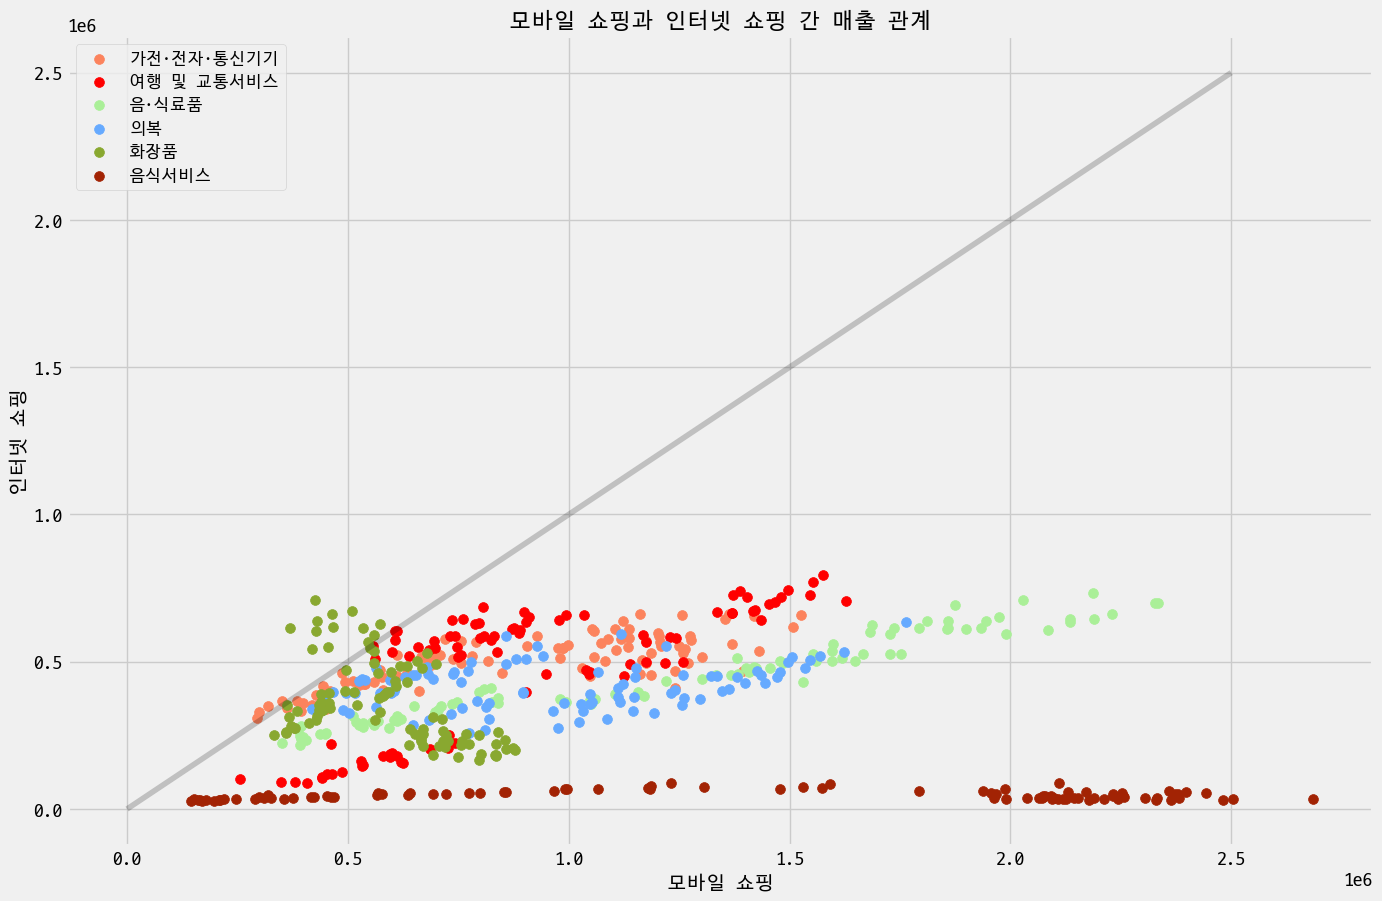

In [24]:
colors = ['#FC835D', 'red', '#AAEF98', '#6AF', '#89A830', '#A22304', 'black']

figure, ax = plt.subplots(figsize=(15,10))

# 산점도 그래프 그리기
for i, cate in enumerate(cate_list):
    category_data = ex1_data[ex1_data['category'] == cate]
    x_data = category_data['mobile']
    y_data = category_data['internet']
    ax.scatter(x_data, y_data, s=50, color=colors[i], label=cate)

# 그래프 제목
ax.set_title('모바일 쇼핑과 인터넷 쇼핑 간 매출 관계', fontsize=16)
# x,y축 레이블
ax.set_xlabel('모바일 쇼핑', fontsize=14)
ax.set_ylabel('인터넷 쇼핑', fontsize=14)

ax.plot([0, 2500000], [0, 2500000], 'k-', alpha=0.2)
# 범례
ax.legend(loc='best', fontsize=12)
# 그래프표시

In [ ]:
colors = ['#FC835D', 'red', '#AAEF98', '#6AF', '#89A830', '#A22304', 'black']

figure, ax = plt.subplots(figsize=(15,10))

# 산점도 그래프 그리기
for i, cate in enumerate(cate_list):
    category_data = ex1_data[ex1_data['category'] == cate]
    x_data = category_data['mobile']
    y_data = category_data['internet']
    ax.scatter(x_data, y_data, s=50, color=colors[i], label=cate)

# 그래프 제목
ax.set_title('모바일 쇼핑과 인터넷 쇼핑 간 매출 관계', fontsize=16)
# x,y축 레이블
ax.set_xlabel('모바일 쇼핑', fontsize=14)
ax.set_ylabel('인터넷 쇼핑', fontsize=14)
# 범례
ax.legend(loc='best', fontsize=12)
# 그래프표시

In [10]:
ex2_data = data_fix[data_fix['category']=='컴퓨터 및 주변기기']
ex2_data.head(10)

,category,date,internet,mobile
0,컴퓨터 및 주변기기,2017-01-01,288391,133993
1,컴퓨터 및 주변기기,2017-02-01,329143,146200
2,컴퓨터 및 주변기기,2017-03-01,322089,151262
3,컴퓨터 및 주변기기,2017-04-01,251604,116675
4,컴퓨터 및 주변기기,2017-05-01,241871,109053
5,컴퓨터 및 주변기기,2017-06-01,262908,113811
6,컴퓨터 및 주변기기,2017-07-01,252949,128025
7,컴퓨터 및 주변기기,2017-08-01,280831,135562
8,컴퓨터 및 주변기기,2017-09-01,270647,128865
9,컴퓨터 및 주변기기,2017-10-01,235350,118174


In [14]:
ex2_data.count()

category    93
date        93
internet    93
mobile      93
dtype: int64

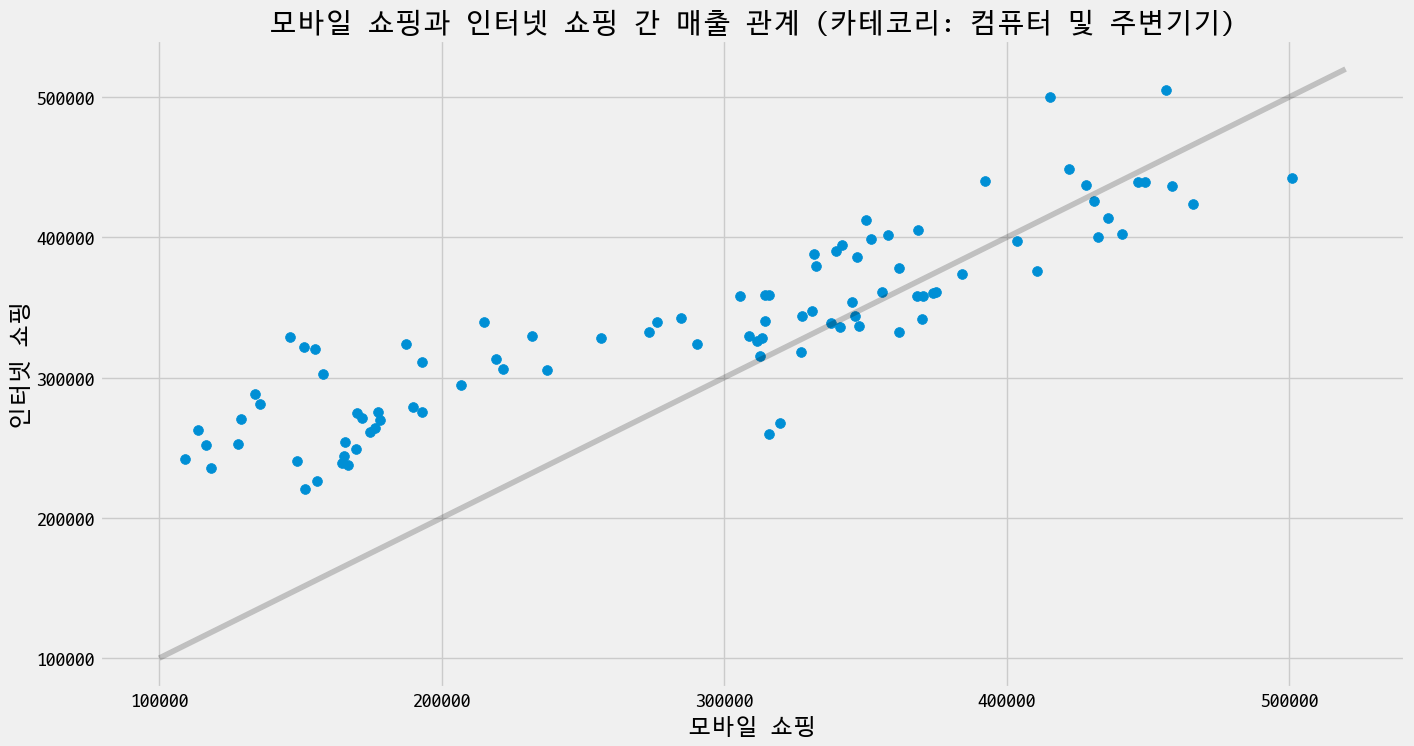

In [26]:
x_data = ex2_data['mobile']
y_data = ex2_data['internet']
fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(x_data, y_data, s=50)
ax.set_title(f'모바일 쇼핑과 인터넷 쇼핑 간 매출 관계 (카테코리: {ex2_data['category'][0]})')
ax.set_xlabel('모바일 쇼핑')
ax.set_ylabel('인터넷 쇼핑')
ax.plot([100000, 520000], [100000, 520000], 'k-', alpha=0.2)